In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tqdm import trange

import cartopy.crs                     as ccrs

import pandas as pd

from datetime import datetime, timedelta

from pyproj import Geod
g = Geod(ellps='WGS84')

import sklearn
from sklearn.model_selection import train_test_split

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, ErrorCode

from utils import createFigurewithProjection, shapeAxis

In [2]:
lon_min, lon_max = -49, -40
lat_min, lat_max = 59, 62

In [3]:
bathy = xr.open_dataset('../data/bathy/GEBCO_02_Dec_2022_8bb5cd71a07e/gebco_2022_n62.0_s59.0_w-49.0_e-40.0.nc')

gdp = xr.open_dataset('../data/GDP/processed_gdp_data.nc')

adsc_file = '../data/ADSC/geo_ekman_daily_gdp.nc'
adsc = xr.open_dataset(adsc_file).isel(depth=0)

In [4]:
DLON = []
DLAT = []
DTIME = []

for n_d in range(len(gdp.traj)):

    drifter = gdp.isel(traj=n_d)

    drifter = drifter.where(~np.isnan(drifter.lon), drop=True)

    drifter = drifter.isel(obs=np.arange(0, len(drifter.time), 4))

    # We only keep trajectory of at least 3 days because our comparison involves 4 locations at the minimum
    if len(drifter.obs)>=4:

        DLON.append(drifter.lon.values)
        DLAT.append(drifter.lat.values)
        DTIME.append(drifter.time.values)

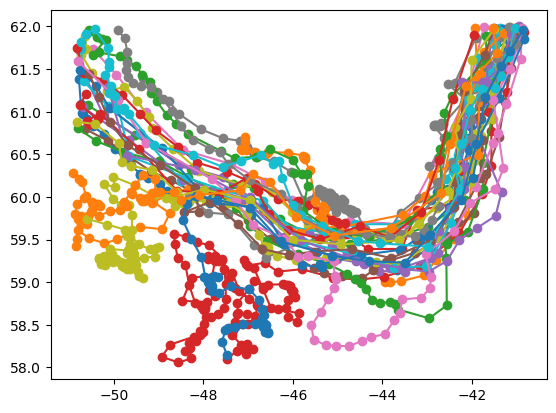

In [5]:
for i in range(len(DLON)):
    plt.plot(DLON[i], DLAT[i], 'o-')

In [6]:
# Sort the data in a temporal order
sort_order = np.argsort([DTIME[i][0] for i in range(len(DTIME))])

DTIME = [DTIME[sort_order[i]] for i in range(len(sort_order))]
DLON = [DLON[sort_order[i]] for i in range(len(sort_order))]
DLAT = [DLAT[sort_order[i]] for i in range(len(sort_order))]

In [7]:
# Remove the last 3 elements of each line from which we cannot compute 4-location skill score
DLON_startings = [DLON[i][:-3] for i in range(len(DLON))]
DLAT_startings = [DLAT[i][:-3] for i in range(len(DLAT))]
DTIME_startings = [DTIME[i][:-3] for i in range(len(DTIME))]

lons = np.concatenate(DLON_startings)
lats = np.concatenate(DLAT_startings)
times = np.concatenate(DTIME_startings)

#Convert np.datetime64 in datetime
timestamp = ((times - np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))
times = np.array([datetime.utcfromtimestamp(timestamp[i]) for i in range(len(timestamp))])

In [8]:
# lons = np.concatenate(DLON)
# lats = np.concatenate(DLAT)
# times = np.concatenate(DTIME)

# lons = lons[times<np.datetime64('2021-12-28T00:00:00.000000000')]
# lats= lats[times<np.datetime64('2021-12-28T00:00:00.000000000')]
# times = times[times<np.datetime64('2021-12-28T00:00:00.000000000')]

# lons = lons[np.argsort(times)]
# lats = lats[np.argsort(times)]
# times = times[np.argsort(times)]

# #Convert np.datetime64 in datetime
# timestamp = ((times - np.datetime64('1970-01-01T00:00:00'))/ np.timedelta64(1, 's'))
# times = np.array([datetime.utcfromtimestamp(timestamp[i]) for i in range(len(timestamp))])

In [9]:
filenames = {'U': adsc_file,
             'V': adsc_file}

variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset_geoek = FieldSet.from_netcdf(filenames, variables, dimensions)

## CREATE AN "AGE" CONSTANT, TO REMOVE TOO OLD PARTICLES
fieldset_geoek.add_constant('maxage', 4*86400)

class AgingParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)

def Age(particle, fieldset, time):
    particle.age = particle.age + math.fabs(5*60) #in seconds, !! CHECK THAT IT CORRESPONDS TO THE DT IN pset.execute(dt) !!
    if particle.age > fieldset.maxage:
        particle.delete()


pset = ParticleSet(fieldset=fieldset_geoek, 
                   pclass=AgingParticle, 
                   lon=lons, 
                   lat=lats,
                   time=times
                  )

def DeleteParticle(particle, fieldset, time):
    particle.delete()

aging_kernel = pset.Kernel(Age)


In [10]:
# output_file = pset.ParticleFile(name="../data/synthetic_trajectories/traj_sim_gdp.zarr", outputdt=timedelta(hours=1))
# pset.execute(AdvectionRK4 + aging_kernel,
#              endtime=np.max(times)+timedelta(days=4),
#              dt=timedelta(minutes=5),
#              output_file=output_file, 
#              recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}
#             )


INFO: Compiled ArrayAgingParticleAdvectionRK4Age ==> /var/folders/pd/6y94_zt968b46d_xrg0jnl6c0000gn/T/parcels-501/libb99cb1f5ae110e8a7c165d9ce1f4cffb_0.so
INFO: Output files are stored in ../data/synthetic_trajectories/traj_sim_gdp.zarr.
100%|█████████▉| 769204800.0/769219200.0 [34:45<00:00, 264121.45it/s]  WARNING: ParticleSet is empty on writing as array at time 8.81986e+08
100%|██████████| 769219200.0/769219200.0 [34:45<00:00, 368787.96it/s]


In [11]:
syn_traj = xr.open_zarr('../data/synthetic_trajectories/traj_sim_gdp.zarr')
syn_traj

<xarray.Dataset>
Dimensions:     (trajectory: 913, obs: 98)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96 97
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 ... 906 907 908 909 910 911 912
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [12]:
i = 128

synth = syn_traj.isel(trajectory=i).isel(obs=np.arange(0, 4*24, 24))
lonsyn, latsyn, timesyn = synth.lon.values, synth.lat.values, synth.time.values

nb_locs = np.concatenate([[0], np.cumsum([len(DLON_startings[i]) for i in range(len(DLON_startings))])])
id_drifter = np.where(i >= nb_locs)[0][-1]
id_loc_in_drifter = i-nb_locs[id_drifter]

lonsyn, latsyn, timesyn

(array([-42.246   , -42.501175, -42.84584 , -43.246986], dtype=float32),
 array([60.304   , 60.050568, 59.87333 , 59.684254], dtype=float32),
 array(['1998-01-17T00:00:00.000000000', '1998-01-18T00:00:00.000000000',
        '1998-01-19T00:00:00.000000000', '1998-01-20T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [13]:
lonref = DLON[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]
latref = DLAT[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]
timeref = DTIME[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]

lonref, latref, timeref

(array([-42.246, -42.542, -42.778, -42.918]),
 array([60.304, 60.099, 60.059, 59.966]),
 array(['1998-01-17T00:00:00.000000000', '1998-01-18T00:00:00.000000000',
        '1998-01-19T00:00:00.000000000', '1998-01-20T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [14]:
def Return3days(i, synth_traj_data):
    
    synth = synth_traj_data.isel(trajectory=i).isel(obs=np.arange(0, 4*24, 24))
    lonsyn, latsyn, timesyn = synth.lon.values, synth.lat.values, synth.time.values

    nb_locs = np.concatenate([[0], np.cumsum([len(DLON_startings[i]) for i in range(len(DLON_startings))])])
    id_drifter = np.where(i >= nb_locs)[0][-1]
    id_loc_in_drifter = i-nb_locs[id_drifter]

    lonref = DLON[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]
    latref = DLAT[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]
    timeref = DTIME[id_drifter][id_loc_in_drifter:id_loc_in_drifter+4]
    
    return lonref, latref, timeref, lonsyn, latsyn, timesyn


def SkillScore(lonref, latref, lonsyn, latsyn):

    d = g.inv(lonref, latref, lonsyn, latsyn)[2]
    dl = g.inv(lonref[:-1], latref[:-1], lonref[1:], latref[1:])[2]

    c = np.sum(d)/np.sum(np.cumsum(dl))

    if c > 1:
        s = 0
    else: 
        s = 1 - c

    return s

In [15]:
longitudes = []
latitudes = []
scores = []
time_score = []

for i in trange(len(syn_traj.trajectory)):

    lonref, latref, timeref, lonsyn, latsyn, timesyn = Return3days(i, syn_traj)

    scores.append(SkillScore(lonref, latref, lonsyn, latsyn))
    
    longitudes.append(lonref[0])
    latitudes.append(latref[0])
    time_score.append(timeref[0])
    
longitudes = np.array(longitudes)
latitudes = np.array(latitudes)
scores = np.array(scores)
time_score = np.array(time_score)

scores = np.array(scores)

good_lon = longitudes[(longitudes>-49)&(longitudes<-40)&(latitudes>59)&(latitudes<62)&(~np.isnan(scores))]
good_lat = latitudes[(longitudes>-49)&(longitudes<-40)&(latitudes>59)&(latitudes<62)&(~np.isnan(scores))]
good_score = scores[(longitudes>-49)&(longitudes<-40)&(latitudes>59)&(latitudes<62)&(~np.isnan(scores))]
good_timescore = time_score[(longitudes>-49)&(longitudes<-40)&(latitudes>59)&(latitudes<62)&(~np.isnan(scores))]

100%|██████████| 913/913 [01:55<00:00,  7.92it/s]


In [18]:
def BootstrapSkillScore(data_input):

    taylor_skill = []

    for i in range(5000):

        mean_input = np.mean(sklearn.model_selection.train_test_split(data_input, test_size=0.1)[0])

        taylor_skill.append(mean_input)

    return np.around(np.nanmean(taylor_skill),2), np.around(np.std(taylor_skill)*1.96, 2)

In [19]:
time_in_months = pd.to_datetime(good_timescore).month
time_in_year = pd.to_datetime(good_timescore).year

np.unique(time_in_months), np.unique(time_in_year)

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12]),
 array([1996, 1997, 1998, 2000, 2002, 2003, 2006, 2007, 2014, 2017, 2018,
        2019, 2020]))

In [38]:
results_gfwe_terific = xr.open_dataset('../data/synthetic_trajectories/results_synth_traj_gfwe_terific_geo_ekman.nc')

augV = results_gfwe_terific.where(results_gfwe_terific.month==8,  drop=True).score.values
sepV = results_gfwe_terific.where(results_gfwe_terific.month==9,  drop=True).score.values
octoV = results_gfwe_terific.where(results_gfwe_terific.month==10,  drop=True).score.values

v2021 = results_gfwe_terific.score.values

In [24]:
jan = good_score[time_in_months==1]
feb = good_score[time_in_months==2]
mar = good_score[time_in_months==3]
apr = good_score[time_in_months==4]
may = good_score[time_in_months==5]
jun = good_score[time_in_months==6]
jul = good_score[time_in_months==7]
aug = good_score[time_in_months==8]
octo = good_score[time_in_months==10]
nov = good_score[time_in_months==11]
dec = good_score[time_in_months==12]

y1996 = good_score[time_in_year==1996]
y1997 = good_score[time_in_year==1997]
y1998 = good_score[time_in_year==1998]
y2000 = good_score[time_in_year==2000]
y2002 = good_score[time_in_year==2002]
y2003 = good_score[time_in_year==2003]
# y2004 = good_score[time_in_year==2004]
y2006 = good_score[time_in_year==2006]
y2007 = good_score[time_in_year==2007]
y2014 = good_score[time_in_year==2014]
# y2015 = good_score[time_in_year==2015]
y2017 = good_score[time_in_year==2017]
y2018 = good_score[time_in_year==2018]
y2019 = good_score[time_in_year==2019]
y2020 = good_score[time_in_year==2020]

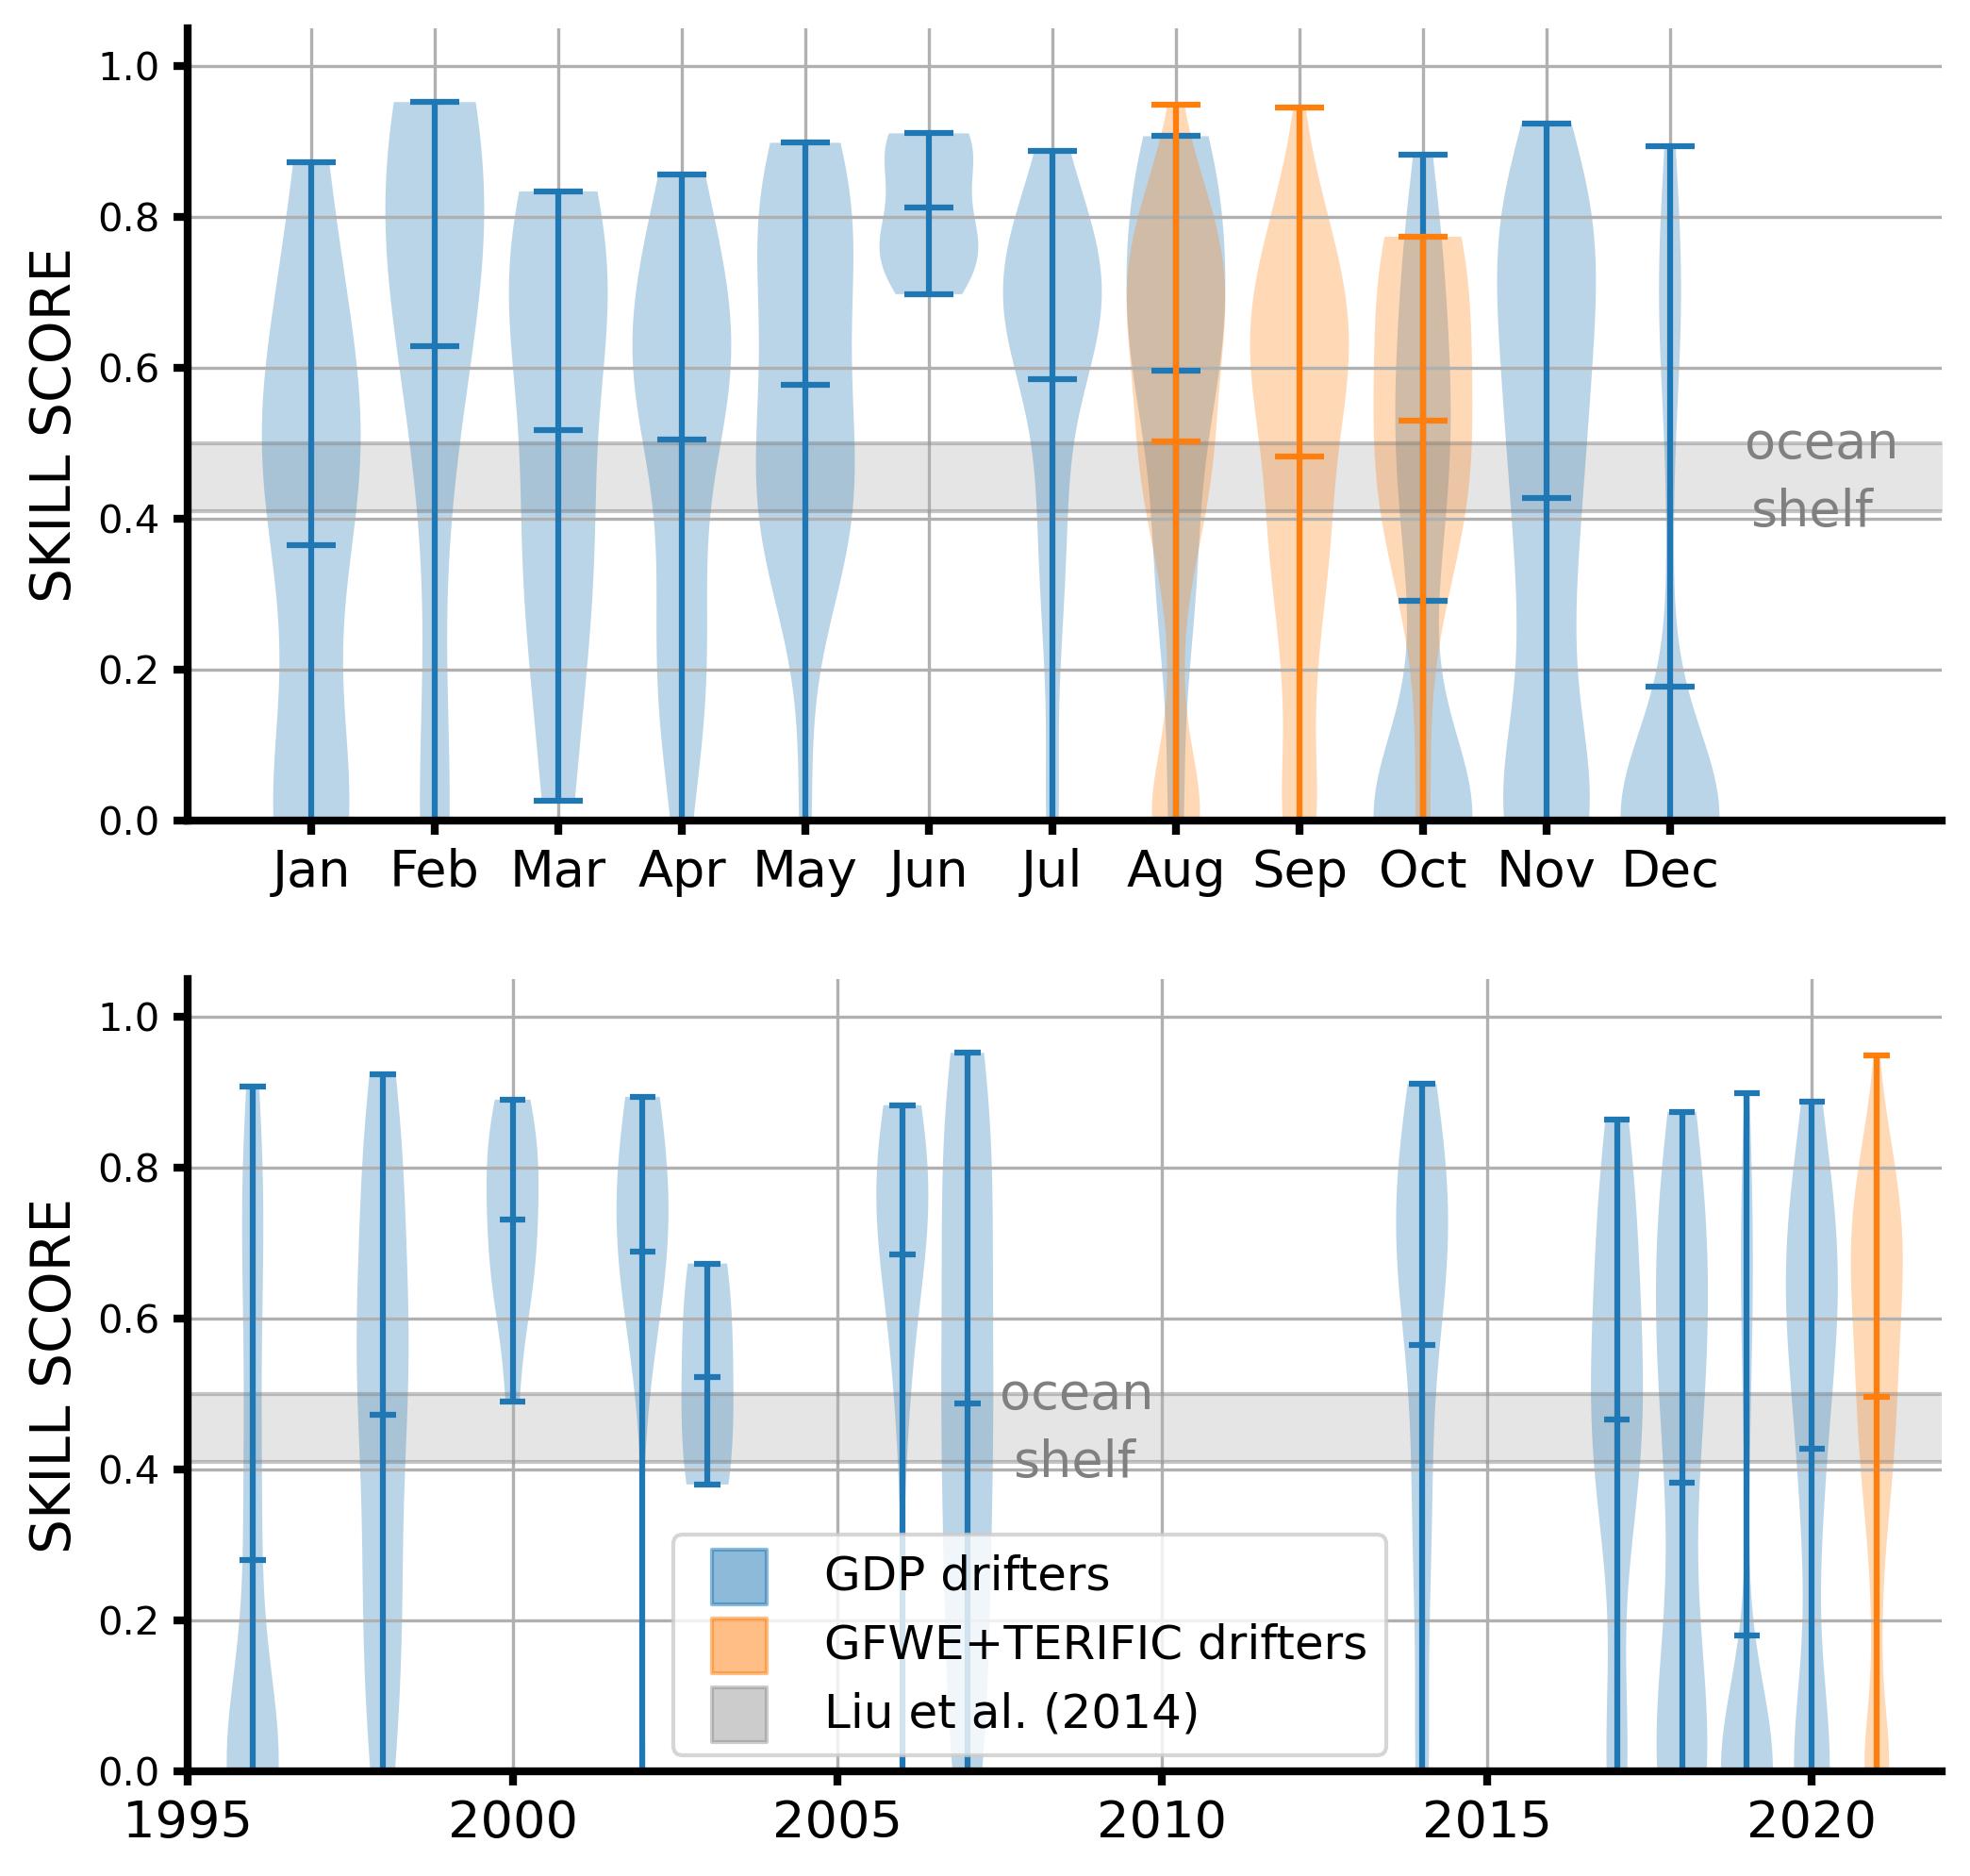

In [39]:
plt.figure(figsize=(8,8), dpi=300)
plt.subplot(211)

plt.fill_between([0, 15], 0.41, 0.5, color='grey', alpha=0.2)
plt.axhline(0.41, color='grey', alpha=0.3, lw=1)
plt.axhline(0.5, color='grey', alpha=0.3, lw=1)

data_to_plot = [jan, feb, mar, apr, may, jun, jul, aug, octo, nov, dec]
pos = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]

plt.violinplot(data_to_plot, pos, showmeans=True, widths=0.8)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0, fontsize=13)
plt.ylim(0, 1.05)
plt.ylabel('SKILL SCORE', fontsize=14)

plt.violinplot([augV, sepV, octoV], [8, 9, 10], showmeans=True, widths=0.8)
plt.xlim(0, 14.2)

plt.text(12.65, 0.39, 'shelf', fontsize=13, c='grey')
plt.text(12.6, 0.48, 'ocean', fontsize=13, c='grey')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2)

plt.subplot(212)

plt.fill_between([1990, 2030], 0.41, 0.5, color='grey', alpha=0.2)
plt.axhline(0.41, color='grey', alpha=0.3, lw=1)
plt.axhline(0.5, color='grey', alpha=0.3, lw=1)

data_to_plot = [y1996, y1997, y1998, y2000, y2002, y2003, y2006, y2007, y2014, y2017, y2018, y2019, y2020]
pos = [1996, 1997, 1998, 2000, 2002, 2003, 2006, 2007, 2014, 2017, 2018, 2019, 2020]

plt.violinplot(data_to_plot, pos, showmeans=True, widths=0.8)

plt.violinplot([v2021], [2021], showmeans=True, widths=0.8)

plt.xticks(fontsize=13)
plt.ylim(0, 1.05)
plt.ylabel('SKILL SCORE', fontsize=14)

plt.scatter(2030, 0.5, s=200,  marker='s', label='GDP drifters', alpha = 0.5)
plt.scatter(2030, 0.5, s=200,  marker='s', label='GFWE+TERIFIC drifters', alpha = 0.5)
plt.scatter(2030, 0.5, s=200,  marker='s', label='Liu et al. (2014)', alpha = 0.4, color='grey')

plt.legend(loc='lower center', fontsize=12, bbox_to_anchor=(0.48, -0.01))
plt.xlim(1995, 2022)
plt.text(2007.7, 0.39, 'shelf', fontsize=13, c='grey')
plt.text(2007.5, 0.48, 'ocean', fontsize=13, c='grey')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2)


In [22]:
BootstrapSkillScore(good_score)

(0.39, 0.01)

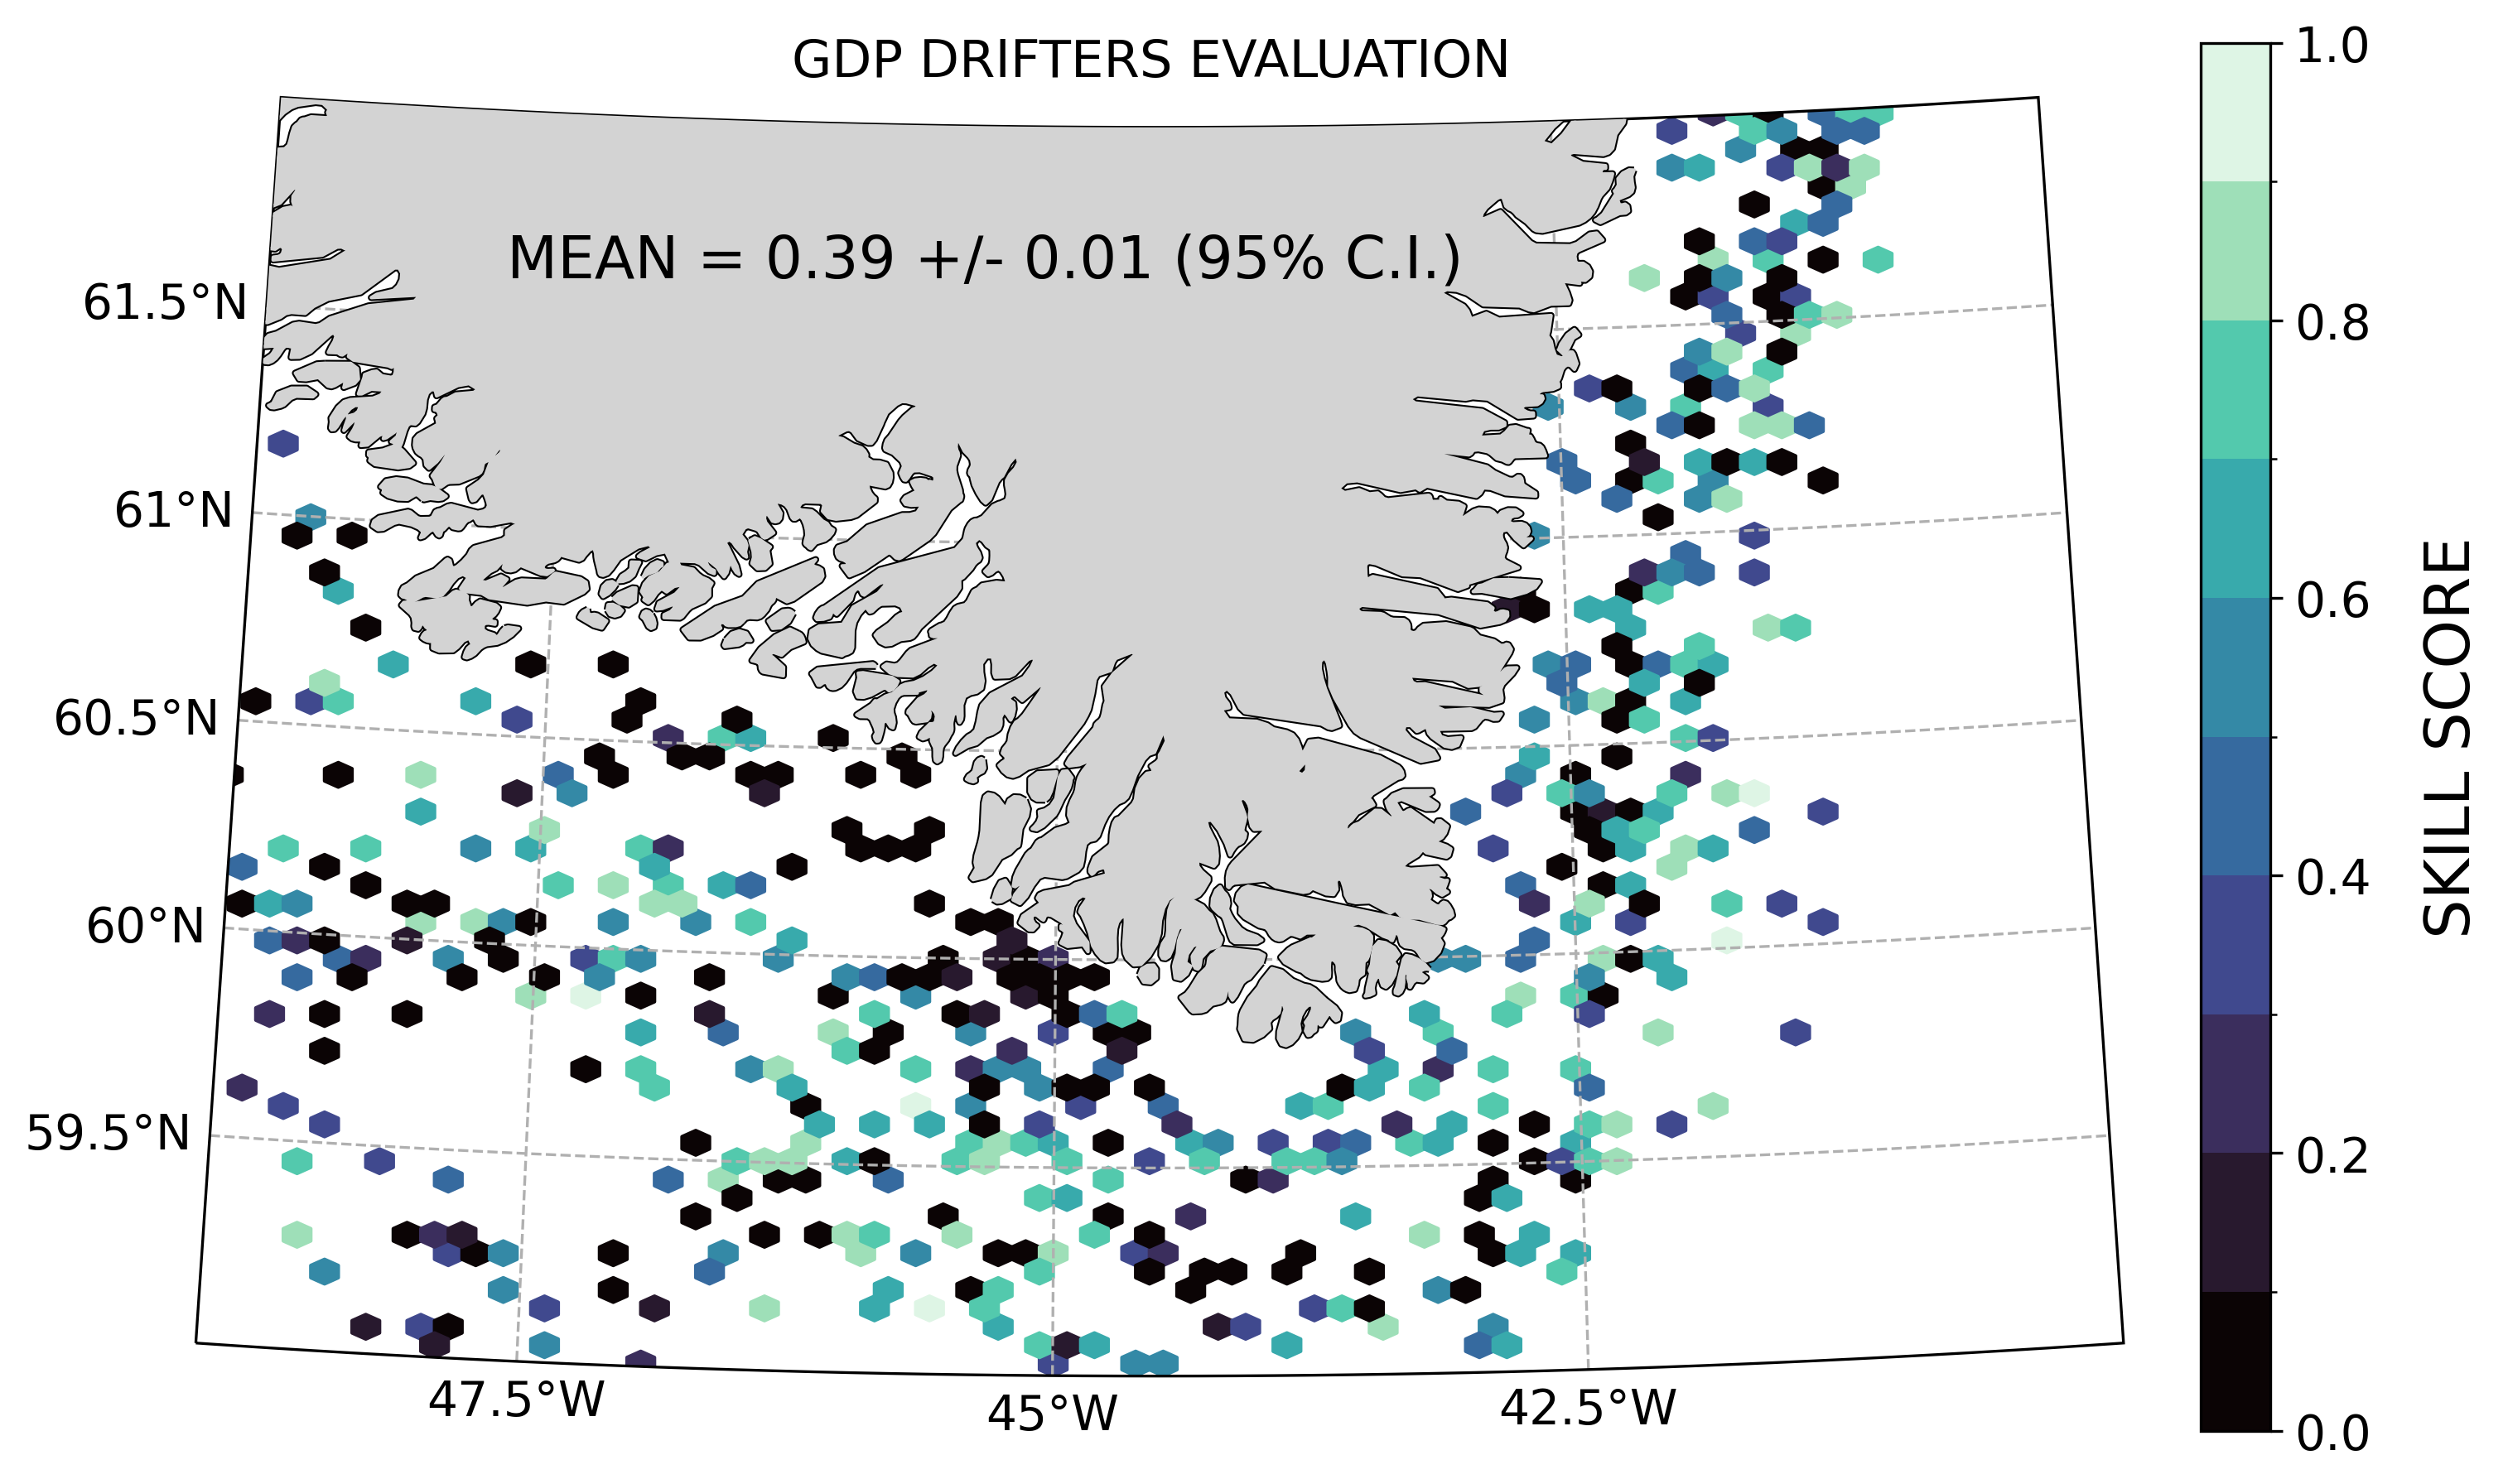

In [26]:
mean, ci = BootstrapSkillScore(good_score)

cmap = sns.color_palette("mako", as_cmap=True)
bounds = np.arange(11)/10
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax, rect = createFigurewithProjection(figsize=(10, 10), nrows=1, ncols=1, bounds=[-49, -40, 59, 62])


ax.set_title('GDP DRIFTERS EVALUATION ', fontsize=15)

shapeAxis(ax, rect, addCoastline=True)

# CS = ax.contour(lon_renske, lat_renske, -bathy_renske, transform=ccrs.PlateCarree(), colors='k', alpha=0.3)
# ax.clabel(CS, CS.levels, inline=True, fontsize=11)


ax.text(-47.8, 61.6,'MEAN = '+str(mean)+' +/- '+str(ci)+' (95% C.I.)', c='k', transform=ccrs.PlateCarree(), fontsize=17)


pc = plt.hexbin(good_lon, good_lat, good_score, gridsize=60, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

cb = fig.colorbar(pc, fraction=0.036, pad=0.040)
cb.ax.tick_params(labelsize=14)
cb.set_label('SKILL SCORE', labelpad=15, y=0.50, rotation=90, fontsize=18)

